# Introduction

We were given the task of providing a recommended salary range for our schools next head football coach. To aid us in answering this question, we collected data regarding current head coach salaries as well as statistics about their performances. Our goal is to analyze this data to aid in creating a model to help predict our offering range.

The sources utilized for our data were: 
* a csv provided by our professor
* revenue data from sports usa today
* stadium data from Collegegridirons
* Graduation data from NCAA
* Win - Loss records from TeamRankings
* and an assortment of additional data from Equity in Athletics

## Libraries

In [ ]:
import numpy as np # arrays and numerical processing
import pandas as pd # DataFrame structure and operations
pd.set_option('display.max_columns', None)
import requests #Allows for GET requests to ping URLs provided.
import bs4 
from bs4 import BeautifulSoup as bs #pulls data out of HTML and XML files
from pandas import DataFrame
import seaborn as sns # Provides trellis and small multiple plotting (scatterplot matrix)
import matplotlib.pyplot as plt
import statsmodels.api as sm  # logistic regression
import statsmodels.formula.api as smf  # R-like model specification
import sklearn #For regression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform #for training and test splitting

In [ ]:
#!pip install python-Levenshtein
#!pip install fuzzymatcher

In [ ]:
import fuzzymatcher

# Data

## Data Sources


### **1) coaches9.csv**

**Description**

* A comma delimited file containing a list of 129 Schools and some metrics for their football team:
  * *Conference, identity of head Coach, SchoolPay, TotalPay, Bonus, BonusPaid, AssistantPay, & Buyout.*

### **2) Revenue Data**

**Description**
* https://sports.usatoday.com/ncaa/finances
* Revenue data for Colleges within the NCAA (National College Athletic Association):
  * *School, Conference, Total Revenue, Total Expenses, Total Allocated, Percent Allocated*

### **3) Stadium Size**
**Description**
* https://www.collegegridirons.com/comparisons-by-capacity/
* Lists the stadium sizes for College Football Stadiums
  * *Stadium, College, Conference, Capacity, Year Opened*



### **4) Graduation Rate**
**Description**
* https://web3.ncaa.org/aprsearch/gsrsearch
* NCAA Graduation Success Rate:
  * *Cohort Year, School, Conference, Sport, State, GSR, FGR, GSR Report, FGR Report*

### **5) Equity in Athletics**
**Description**
* https://ope.ed.gov/athletics/#/
* 2020 Statistics
* Extremely Numerous variables for understanding collegiate expense and revenue.
* Variables of interest: 
  * *Unit ID, Institution Name, addr1, addr2, Number of Participants in Mens football, Number of participants Womens Football, Total OPEX for Football, Total num of head coaches for mens football, Total num of head coaches for womens football, total assistant coaches mens football, total assistant coaches womens football, total revenue for men and womens football per team, total expenses for men and womens football per team.*

### **6) Team Win/Loss Record**
**Description**
* https://www.teamrankings.com/ncf/trends/win_trends/
* Data on team wins and losses:
  * *Team, Win-Loss Record, Win%, MOV, ATS+/-*

## Data Import, Subsetting, and Count of Missing Values

* **Connect to google Drive file directory**

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Change the directory to our google Drive
%cd /content/drive/My\ Drive/Colab\ Notebooks/IST718/Homework/Lab3

#Check where we are located
!pwd

/content/drive/My Drive/Colab Notebooks/IST718/Homework/Lab3
/content/drive/My Drive/Colab Notebooks/IST718/Homework/Lab3


### **coaches9.csv**

* Import .csv file and save as coachesRAW

In [ ]:
coachesRAW = pd.read_csv('Coaches9.csv', sep = ',', header=0, na_values = ['--'])
#Create a pandas data frame containing the csv file information and have the first row be the header.
#Note the addition of declaring how our empty values will look. If we don't include this, Python won't be able to recognize them as NaN and then we search to see if we have taken care of them, it will confuse us. 
print(coachesRAW.head()) #Show the first 5 rows of data, all columns

                  School Conference              Coach    SchoolPay  \
0              Air Force   Mt. West       Troy Calhoun       885000   
1                  Akron        MAC       Terry Bowden    $411,000    
2                Alabama        SEC         Nick Saban  $8,307,000    
3  Alabama at Birmingham      C-USA         Bill Clark    $900,000    
4      Appalachian State   Sun Belt  Scott Satterfield    $712,500    

      TotalPay        Bonus  BonusPaid AssistantPay        Buyout  
0       885000       247000        NaN          $0            NaN  
1    $412,500     $225,000    $50,000           $0      $688,500   
2  $8,307,000   $1,100,000   $500,000           $0   $33,600,000   
3    $900,000     $950,000   $165,471           $0    $3,847,500   
4    $712,500     $295,000   $145,000           $0    $2,160,417   


* Variables of interest: 
  * School, Conference, Coach, TotalPay, Bonus, & AssistantPay.

* Variables being excluded: 
  * School Pay: This is repetitive with TotalPay
  * BonusPaid: Repetitive with Bonus
  * Buyout: We are told not to include this variable.

* Subset desired variables into new data frame: coaches

In [ ]:
# Use [[]] to subset. The outer select the data from the data frame and the inner brackets define a Python list
coaches = coachesRAW[['School', 'Conference', 'Coach', 'TotalPay', 'Bonus', 'AssistantPay']]
coaches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   School        129 non-null    object
 1   Conference    129 non-null    object
 2   Coach         129 non-null    object
 3   TotalPay      125 non-null    object
 4   Bonus         107 non-null    object
 5   AssistantPay  129 non-null    object
dtypes: object(6)
memory usage: 6.2+ KB


* Check numbers of missing values.

In [ ]:
print(coaches.isna().sum())
#There are 4 instances of missing values in the Coach column
#There are 22 instances of missing values in the Bonus column
  #coachesRAW['BonusPaid'].isna().sum() Double check that the BonusPaid column contains more NaN's than the Bonus column. Keep Bonus Column. 

print(coaches.duplicated().sum()) #No duplicated records

School           0
Conference       0
Coach            0
TotalPay         4
Bonus           22
AssistantPay     0
dtype: int64
0


* Wait to deal with these NaN's until after joining. We want at least 80 rows in our final document. Currenttly, our data frame contains 6 columns and 129 entries. 
* 129 - 26 = 103 entities still remaining. But wait to see how our joining goes.

### **Revenue Data**

In [ ]:
#Scrape in revenue data from NCAA
revenueRAW = pd.read_html("https://sports.usatoday.com/ncaa/finances") #THIS RETURNS A LIST OF DATAFRAME
len(revenueRAW)
print(revenueRAW[0])

      Rk                    School     Conf  Total Revenue  Total Expenses  \
0      1                     Texas   Big 12   $223,879,781    $204,234,897   
1      2                 Texas A&M      SEC   $212,748,002    $169,012,456   
2      3                Ohio State  Big Ten   $210,548,239    $220,572,956   
3      4                  Michigan  Big Ten   $197,820,410    $190,952,175   
4      5                   Georgia      SEC   $174,042,482    $143,299,554   
..   ...                       ...      ...            ...             ...   
223  224    Maryland-Eastern Shore     MEAC     $5,305,668      $5,305,668   
224  225  Mississippi Valley State     SWAC     $4,107,811      $4,107,811   
225  226            Savannah State     MEAC     $4,030,759      $5,068,318   
226  227              Coppin State     MEAC     $3,225,541      $4,603,198   
227   Rk                    School     Conf  Total Revenue  Total Expenses   

     Total Allocated  % Allocated  
0                 $0       

In [ ]:
revenueRAWdf = revenueRAW[0] #THIS SHOULD BE THE DATAFRAME and not the list! YES.

* Variables of interest:
  * School, Conference, Total Revenue, & Total Expenses.

* Variables excluded:
  * Total Allocated & % Allocated: we just want the revenue and expense data.

In [ ]:
#Select the variables of interest.
revenue = revenueRAWdf[['School', 'Conf', 'Total Revenue', 'Total Expenses']]

#Any missing data?
print(revenue.isna().sum()) #Looks like there aren't any.
print(revenue.duplicated().sum()) #No duplicates

School            0
Conf              0
Total Revenue     0
Total Expenses    0
dtype: int64
0


### **Stadium Size**

In [ ]:
#Try scraping from the collegegridirons page
stadiumRAW = pd.read_html("https://www.collegegridirons.com/comparisons-by-capacity/") #THIS IS A LIST OF DATAFRAME
len(stadiumRAW)
print(stadiumRAW) #Amazing. Python is amazing.

[                      Stadium           College   Conference  Capacity  Opened
0            Michigan Stadium          Michigan      Big Ten    107601    1927
1              Beaver Stadium        Penn State      Big Ten    106572    1960
2                Ohio Stadium        Ohio State      Big Ten    104944    1922
3                  Kyle Field         Texas A&M          SEC    102733    1904
4             Neyland Stadium         Tennessee          SEC    102521    1921
..                        ...               ...          ...       ...     ...
126             Foreman Field      Old Dominion         CUSA     20118    1936
127           McGuirk Stadium             UMass  Independent     17000    1965
128               Kibbie Dome             Idaho     Sun Belt     16000    1975
129  Jerry Richardson Stadium     UNC Charlotte         CUSA     15314    2013
130            Brooks Stadium  Coastal Carolina     Sun Belt     15000    2003

[131 rows x 5 columns]]


In [ ]:
#Pull the dataframe out of the list
stadiumRAWdf = stadiumRAW[0]
stadiumRAWdf.head()

,Stadium,College,Conference,Capacity,Opened
0,Michigan Stadium,Michigan,Big Ten,107601,1927
1,Beaver Stadium,Penn State,Big Ten,106572,1960
2,Ohio Stadium,Ohio State,Big Ten,104944,1922
3,Kyle Field,Texas A&M,SEC,102733,1904
4,Neyland Stadium,Tennessee,SEC,102521,1921


* Variables of interest:
  * College, Conference, Capacity, & Opened.
  
* Variables being excluded:
  * Stadium: we don't need this name for any analysis.

In [ ]:
stadium = stadiumRAWdf[['College', 'Conference', 'Capacity', 'Opened']]

* Check for missing data

In [ ]:
print(stadium.isna().sum()) #No NA's in the data.
print(stadium.duplicated().sum()) #No duplicates

College       0
Conference    0
Capacity      0
Opened        0
dtype: int64
0


### **Graduation Rate**

* This data gave me trouble for web scraping. As per the suggestion of Arun Ojha, I chose to copy all of the data into a notepad, remove unnecessary text, and save it as a tsv file to load into pandas. It will be included in the google colab file.

In [ ]:
gradRAW = pd.read_csv("grad.tsv", sep='\t', header=0)

gradRAW.head()

,Cohort Year,School,Conference,Sport,State,GSR,FGR,GSR Report,FGR Report
0,2013,Abilene Christian University,Southland Conference,Football,TX,74.00,53.00,nan,nan
1,2013,Alabama A&M University,Southwestern Athletic Conf.,Football,AL,58.00,48.00,nan,nan
2,2013,Alabama State University,Southwestern Athletic Conf.,Football,AL,67.00,41.00,nan,nan
3,2013,Alcorn State University,Southwestern Athletic Conf.,Football,MS,63.00,47.00,nan,nan
4,2013,Appalachian State University,Sun Belt Conference,Football,NC,77.00,65.00,nan,nan


* Variables of interest:
  * School, Conference, GSR (Graduation Success Rate), & FGR ().

* Variables being excluded: 
  * Cohort, Year, Sport, State, GSR Report, & FGR Report.

In [ ]:
#Subset desired columns
grad = gradRAW[['School', 'Conference', 'GSR', 'FGR']]
print(grad.isna().sum()) 
#There are 20 schools missing their FGR and one school missing their GSR.

School         0
Conference     0
GSR            1
FGR           20
dtype: int64


* Remove the few schools with NaN.

In [ ]:
grad = grad.dropna()
print(grad.isna().sum())
print(grad.duplicated().sum()) #No duplicates

School        0
Conference    0
GSR           0
FGR           0
dtype: int64
0


### **Equity in Athletics**

In [ ]:
# Will provide excel and word file of interest in the google colab docs
excessiveRAW = pd.read_excel("EADA_2020.xlsx") 

* Variables of interest determined from metadata:
  * unitid
  * institution_name 
  * addr1_txt
  * addr2_txt
  * city_txt
  * classification_name
  * PARTIC_MEN_Football 
  * PARTIC_WOMEN_Football 
  * TOTAL_OPEXP_MENWOMEN_Football
  * MEN_TOTAL_HEADCOACH_Football
  * WOMEN_TOTAL_HDCOACH_Football
  * MEN_TOTAL_ASSTCOACH_Football
  * WOMEN_TOTAL_ASTCOACH_Football
  * TOTAL_REV_MENWOMEN_Football
  * TOTAL_EXP_MENWOMEN_Football

In [ ]:
#Subset the desired attributes into a new data frame
exces = excessiveRAW[['unitid','institution_name','addr1_txt','addr2_txt','city_txt','classification_name','PARTIC_MEN_Football','PARTIC_WOMEN_Football','TOTAL_OPEXP_MENWOMEN_Football','MEN_TOTAL_HEADCOACH_Football','WOMEN_TOTAL_HDCOACH_Football','MEN_TOTAL_ASSTCOACH_Football','WOMEN_TOTAL_ASTCOACH_Football','TOTAL_REV_MENWOMEN_Football','TOTAL_EXP_MENWOMEN_Football']]

exces.head()

exces.isna().sum()

unitid                              0
institution_name                    0
addr1_txt                           0
addr2_txt                        2024
city_txt                            1
classification_name                 0
PARTIC_MEN_Football              1190
PARTIC_WOMEN_Football            2073
TOTAL_OPEXP_MENWOMEN_Football    1190
MEN_TOTAL_HEADCOACH_Football     1190
WOMEN_TOTAL_HDCOACH_Football     2073
MEN_TOTAL_ASSTCOACH_Football     1191
WOMEN_TOTAL_ASTCOACH_Football    2073
TOTAL_REV_MENWOMEN_Football      1190
TOTAL_EXP_MENWOMEN_Football      1190
dtype: int64

* We see that most of the fields that are specific to Women's Football have almost double the NA values as their Male counterparts. Additionally, the address line 2 is normally empty. We will remove these attributes.

In [ ]:
exces = exces[['unitid','institution_name','addr1_txt','city_txt','classification_name','PARTIC_MEN_Football','TOTAL_OPEXP_MENWOMEN_Football','MEN_TOTAL_HEADCOACH_Football','MEN_TOTAL_ASSTCOACH_Football','TOTAL_REV_MENWOMEN_Football','TOTAL_EXP_MENWOMEN_Football']]

exces.isna().sum()

exces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   unitid                         2073 non-null   int64  
 1   institution_name               2073 non-null   object 
 2   addr1_txt                      2073 non-null   object 
 3   city_txt                       2072 non-null   object 
 4   classification_name            2073 non-null   object 
 5   PARTIC_MEN_Football            883 non-null    float64
 6   TOTAL_OPEXP_MENWOMEN_Football  883 non-null    float64
 7   MEN_TOTAL_HEADCOACH_Football   883 non-null    float64
 8   MEN_TOTAL_ASSTCOACH_Football   882 non-null    float64
 9   TOTAL_REV_MENWOMEN_Football    883 non-null    float64
 10  TOTAL_EXP_MENWOMEN_Football    883 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 178.3+ KB


* If we only take the complete cases, we will still have 882 records. Let's do this.

In [ ]:
exces.dropna(axis=0, how='any', inplace= True) #We chose axis = 0 as we want to drop rows containing NA, not columns (axis = 1)
print(exces.isna().sum())
print(exces.duplicated().sum()) #No duplicates

unitid                           0
institution_name                 0
addr1_txt                        0
city_txt                         0
classification_name              0
PARTIC_MEN_Football              0
TOTAL_OPEXP_MENWOMEN_Football    0
MEN_TOTAL_HEADCOACH_Football     0
MEN_TOTAL_ASSTCOACH_Football     0
TOTAL_REV_MENWOMEN_Football      0
TOTAL_EXP_MENWOMEN_Football      0
dtype: int64
0


### **Team Win/Loss Data** 

In [ ]:
winLossRAW = pd.read_html("https://www.teamrankings.com/ncf/trends/win_trends/") #List of data frame
print(winLossRAW)

[             Team Win-Loss Record   Win %    MOV  ATS +/-
0         Alabama          13-0-0  100.0%  29.10     7.00
1             BYU          11-1-0   91.7%  28.20     9.40
2     Coastal Car          11-1-0   91.7%  16.90    12.00
3    LA Lafayette          10-1-0   90.9%  11.60     1.40
4         Liberty          10-1-0   90.9%  17.60     7.90
..            ...             ...     ...    ...      ...
122  Florida Intl           0-5-0    0.0% -10.00    -8.10
123        U Mass           0-4-0    0.0% -37.20    -1.50
124       Arizona           0-5-0    0.0% -22.40   -12.10
125    Vanderbilt           0-9-0    0.0% -22.60    -2.70
126        Kansas           0-9-0    0.0% -30.20    -9.20

[127 rows x 5 columns]]


In [ ]:
winLossRAWdf = winLossRAW[0]
winLossRAWdf.head()

,Team,Win-Loss Record,Win %,MOV,ATS +/-
0,Alabama,13-0-0,100.0%,29.10,7.00
1,BYU,11-1-0,91.7%,28.20,9.40
2,Coastal Car,11-1-0,91.7%,16.90,12.00
3,LA Lafayette,10-1-0,90.9%,11.60,1.40
4,Liberty,10-1-0,90.9%,17.60,7.90


* Variables of interest:
  * Team, Win %, MOV (Margin of Victory), ATS (Against The Spread).

* Variables being excluded:
  * Win-Loss Record: Looking at Win % will be more informative.

In [ ]:
#Subset desried variables into new column
winLoss = winLossRAWdf[['Team', 'Win %', 'MOV', 'ATS +/-']]

print(winLoss.isna().sum())
print(winLoss.duplicated().sum()) #No duplicates

Team       0
Win %      0
MOV        0
ATS +/-    0
dtype: int64
0


## Data Joining and Cleaning

### Data Frames

* **coaches:** 
  * School, Conference, Coach, TotalPay, Bonus, & AssistantPay
* **revenue:** 
  * School, Conference, Total Revenue, & Total Expenses
* **stadium:** 
  * Stadium, College, Conference, Capacity, & Opened
* **winLoss:** 
  * Team, Win %, MOV, ATS +/-
* **grad:** 
  * School, Conference, GSR, & FGR
* **exces:** 
  * unitid, institution_name, addr1_txt, city_txt, classification_name,  PARTIC_MEN_Football, TOTAL_OPEXP_MENWOMEN_Football,MEN_TOTAL_HEADCOACH_Football, MEN_TOTAL_ASSTCOACH_Football,TOTAL_REV_MENWOMEN_Football, TOTAL_EXP_MENWOMEN_Football

### NaN Values in Data Frames

* We have removed records containing missing data from all data frames except coaches.
  * coaches has 26 NaN records. After joining, we will see how many rows have complete data and then decided how to proceed after that.

### Joining Data Frames with Similar or Identical Column Names

* coaches, revenue, and grad all have **School** and **Conference** in common.

* how similar are their entries in these columns?
  * There are enough differences to mandate the use of **fuzzymatcher** in order to be able to retain more entries.

#### Merge coaches and revenue

In [ ]:
coaches.head(n=2)


,School,Conference,Coach,TotalPay,Bonus,AssistantPay
0,Air Force,Mt. West,Troy Calhoun,885000,247000,$0
1,Akron,MAC,Terry Bowden,"$412,500","$225,000",$0


In [ ]:
#Merge coaches and revenue
left_on = ['School', 'Conference'] #The column names we want to join on from coaches
right_on = ['School', 'Conf'] #The column names we want to join on from revenue

In [ ]:
dfJOINED1 = fuzzymatcher.fuzzy_left_join(coaches, revenue, left_on, right_on) #This gives us rankings on naming conventions found in the columns we want to join on.

In [ ]:
#Utilize the fuzzy matcher results to create a data frame.
dfJOINED1 = pd.DataFrame(dfJOINED1) #Dataframe creation
#Utilize the best_match_score column to see what our best choices are for joining on.
dfjoined1 = dfJOINED1.sort_values(by='best_match_score', ascending = False) 

In [ ]:
#Rename columns so we can keep track of them.
dfjoined1.rename(columns={'School_left':'coaches_School', 'Conference':'coaches_Conference', 'School_right':'revenue_School', 'Conf':'revenue_Conf'}, inplace=True)
print(dfjoined1.head(n=2))

     best_match_score __id_left __id_right    coaches_School  \
172              0.73   72_left   63_right  Nevada-Las Vegas   
229              0.70   94_left  101_right    San Jose State   

    coaches_Conference          Coach   TotalPay      Bonus AssistantPay  \
172           Mt. West   Tony Sanchez  $600,000   $260,000           $0    
229           Mt. West  Brent Brennan  $590,424   $210,000           $0    

       revenue_School revenue_Conf Total Revenue Total Expenses  
172  Nevada-Las Vegas     Mt. West   $50,784,275    $50,445,250  
229    San Jose State     Mt. West   $32,787,377    $33,184,068  


* We can see that the majority of occurences seem to be matched correctly. 
* We will wait till the very last merge before we delete any rows or additional columns. 
  * This leaves us the opportunity to see if there are school names from coaches that match with some merges but not others.

In [ ]:
#Starting with joined1_remove
dfjoined1_remove = dfjoined1.drop(['best_match_score','__id_left', '__id_right'], axis=1)

#### Merge grad in with coaches and revenue

In [ ]:
grad.head(n=2)

,School,Conference,GSR,FGR
0,Abilene Christian University,Southland Conference,74.00,53.00
1,Alabama A&M University,Southwestern Athletic Conf.,58.00,48.00


In [ ]:
print(dfjoined1_remove.head(n=2))

       coaches_School coaches_Conference          Coach   TotalPay      Bonus  \
172  Nevada-Las Vegas           Mt. West   Tony Sanchez  $600,000   $260,000    
229    San Jose State           Mt. West  Brent Brennan  $590,424   $210,000    

    AssistantPay    revenue_School revenue_Conf Total Revenue Total Expenses  
172          $0   Nevada-Las Vegas     Mt. West   $50,784,275    $50,445,250  
229          $0     San Jose State     Mt. West   $32,787,377    $33,184,068  


In [ ]:
left_on = ['coaches_School', 'coaches_Conference']
right_on = ['School', 'Conference']
#Set up the rankings of matches
dfJOINED2 = fuzzymatcher.fuzzy_left_join(dfjoined1_remove, grad, left_on, right_on)

In [ ]:
dfJOINED2 = pd.DataFrame(dfJOINED2) #Dataframe creation
#Utilize the best_match_score column to see what our best choices are for joining on.
dfjoined2 = dfJOINED2.sort_values(by='best_match_score', ascending = False)

In [ ]:
print(dfjoined2.head(n=2))

    best_match_score __id_left __id_right    coaches_School  \
20              0.64    9_left   49_right  Georgia Southern   
23              0.61   12_left  227_right     West Virginia   

   coaches_Conference           Coach     TotalPay        Bonus AssistantPay  \
20           Sun Belt   Chad Lunsford    $650,000     $295,000           $0    
23             Big 12  Dana Holgorsen  $3,617,500   $1,000,000           $0    

      revenue_School revenue_Conf Total Revenue Total Expenses  \
20  Georgia Southern     Sun Belt   $29,483,912    $29,504,873   
23     West Virginia       Big 12  $102,680,928    $98,249,890   

                         School           Conference   GSR   FGR  
20  Georgia Southern University  Sun Belt Conference 67.00 58.00  
23     West Virginia University    Big 12 Conference 69.00 58.00  


In [ ]:
dfjoined2_remov = dfjoined2.drop(['best_match_score', '__id_left', '__id_right'], axis=1)

In [ ]:
#Rename Columns to keep organized
dfjoined2_remov.columns= ['coaches_School', 'coaches_Conference', 'Coach', 'TotalPay', 'Bonus', 'AssistantPay', 'revenue_School', 'revenue_Conference', 'TotalRevenue', 'TotalExpenses', 'grad_School', 'grad_Conference', 'GSR', 'FGR']


In [ ]:
dfjoined2_remov.head(n=2)

,coaches_School,coaches_Conference,Coach,TotalPay,Bonus,AssistantPay,revenue_School,revenue_Conference,TotalRevenue,TotalExpenses,grad_School,grad_Conference,GSR,FGR
20,Georgia Southern,Sun Belt,Chad Lunsford,"$650,000","$295,000",$0,Georgia Southern,Sun Belt,"$29,483,912","$29,504,873",Georgia Southern University,Sun Belt Conference,67.00,58.00
23,West Virginia,Big 12,Dana Holgorsen,"$3,617,500","$1,000,000",$0,West Virginia,Big 12,"$102,680,928","$98,249,890",West Virginia University,Big 12 Conference,69.00,58.00


### Join Data Frames with Unique Collumn Names

* winLoss, exces, stadium


#### Merge stadium in with grad + coachs + revenue

In [ ]:
stadium.head()

,College,Conference,Capacity,Opened
0,Michigan,Big Ten,107601,1927
1,Penn State,Big Ten,106572,1960
2,Ohio State,Big Ten,104944,1922
3,Texas A&M,SEC,102733,1904
4,Tennessee,SEC,102521,1921


In [ ]:
#Start with dfjoined2_remov

#Set up columns to merge on
left_on = ['coaches_School', 'coaches_Conference']
right_on = ['College', 'Conference']

#Join and get rankings
dfJOINED3 = fuzzymatcher.fuzzy_left_join(dfjoined2_remov, stadium, left_on, right_on)
#Turn it into a DF
dfJOINED3 = pd.DataFrame(dfJOINED3)
#Sort by the best matches
dfjoined3 = dfJOINED3.sort_values(by='best_match_score', ascending = False)

* These all look pretty good. 
* Only issues that I see are the two last rows. 
  * Stadium identifies both as North Texas while the merged file identifies the first as Texas-San Antonio and the second as Texas-El Paso.
  * This means that both schools will be given the same stadium capacity. 

* texas San Antonio stadium capacity = 72000
* texas El Paso stadium capacity = 51500
  * We will change both of these entries to their proper value.

In [ ]:
#Function at and iat are for single element in data frame (scalar); loc and iloc are for accessing multiple values, potentially doing vectorized operations.
  #loc: only work on index
  #iloc: work on position
  #at: get scalar values. It's a very fast loc
  #iat: Get scalar values. It's a very fast iloc
#Because we organized the data frame, the indexes are all messed up but they are located on the left-most side or each row.

# Change Column = Capacity to 72000 where School_Left = Texas-San Antonio
#San Antonio
dfjoined3.at[25, 'grad_School']
dfjoined3.at[25, 'Capacity']=72000

In [ ]:
# Change Column = Capacity to 51500 where School_Left = Texas-El Paso
#El Paso
dfjoined3.at[15, 'grad_School']
dfjoined3.at[15, 'Capacity']=51500

In [ ]:
print(dfjoined3.tail())

     best_match_score __id_left __id_right     coaches_School  \
25              -0.14   20_left   97_right  Texas-San Antonio   
15              -0.15   14_left   97_right      Texas-El Paso   
95                nan   54_left       None      Brigham Young   
164               nan   93_left       None            Liberty   
191               nan  118_left       None      Massachusetts   

    coaches_Conference          Coach     TotalPay      Bonus AssistantPay  \
25               C-USA   Frank Wilson  $1,100,000   $185,000           $0    
15               C-USA     Dana Dimel    $700,000   $741,665           $0    
95                Ind.  Kalani Sitake          NaN        NaN          $0    
164               Ind.    Turner Gill    $947,281         NaN          $0    
191               Ind.   Mark Whipple    $500,000   $305,000           $0    

        revenue_School revenue_Conference TotalRevenue TotalExpenses  \
25   Texas-San Antonio              C-USA  $33,657,739   $32,278,508

In [ ]:
dfjoined3_remove = dfjoined3.drop(['best_match_score', '__id_left', '__id_right'], axis=1)

In [ ]:
#Rename columns for organization
dfjoined3_remove.columns= ['coaches_School', 'coaches_Conference', 'Coach', 'TotalPay', 'Bonus', 'AssistantPay', 'revenue_School', 'revenue_Conference', 'TotalRevenue', 'TotalExpenses', 'grad_School', 'grad_Conference', 'GSR', 'FGR', 'stadium_College', 'stadium_Conference', 'Capacity', 'Opened']


#### Merge winLoss with grad+ revenue+ coaches+ stadium

In [ ]:
print(winLoss.head(n=2))
print(dfjoined3_remove.head(n=2))

      Team   Win %   MOV  ATS +/-
0  Alabama  100.0% 29.10     7.00
1      BYU   91.7% 28.20     9.40
       coaches_School coaches_Conference          Coach   TotalPay      Bonus  \
0    Georgia Southern           Sun Belt  Chad Lunsford  $650,000   $295,000    
92  Northern Illinois                MAC      Rod Carey  $633,460   $205,000    

   AssistantPay     revenue_School revenue_Conference TotalRevenue  \
0           $0    Georgia Southern           Sun Belt  $29,483,912   
92          $0   Northern Illinois                MAC  $28,057,388   

   TotalExpenses                   grad_School          grad_Conference   GSR  \
0    $29,504,873   Georgia Southern University      Sun Belt Conference 67.00   
92   $26,483,239  Northern Illinois University  Mid-American Conference 84.00   

     FGR    stadium_College stadium_Conference  Capacity  Opened  
0  58.00   Georgia Southern           Sun Belt  24300.00 1984.00  
92 65.00  Northern Illinois                MAC  24000.00 1965.00 

* Join on School_left and Team

In [ ]:
#Set up columns to merge on
left_on = ['coaches_School']
right_on=['Team']

#Join and get rankings
dfJOINED4 = fuzzymatcher.fuzzy_left_join(dfjoined3_remove, winLoss, left_on, right_on)
#Turn it into a DF
dfJOINED4 = pd.DataFrame(dfJOINED4)
#Sort by the best matches
dfjoined4 = dfJOINED4.sort_values(by='best_match_score', ascending = False)


In [ ]:
print(dfjoined4.head(n=2))

    best_match_score __id_left __id_right coaches_School coaches_Conference  \
10              0.39    6_left    6_right      Texas A&M                SEC   
25              0.39    8_left   72_right    Wake Forest                ACC   

           Coach     TotalPay        Bonus AssistantPay revenue_School  \
10  Jimbo Fisher  $7,500,000   $1,350,000           $0       Texas A&M   
25  Dave Clawson  $1,831,580           NaN          $0        Virginia   

   revenue_Conference  TotalRevenue TotalExpenses  \
10                SEC  $212,748,002  $169,012,456   
25                ACC  $110,219,117  $112,621,238   

                              grad_School            grad_Conference   GSR  \
10  Texas A&M University, College Station    Southeastern Conference 73.00   
25                 Wake Forest University  Atlantic Coast Conference 88.00   

     FGR stadium_College stadium_Conference  Capacity  Opened         Team  \
10 55.00       Texas A&M                SEC 102733.00 1904.00    T

* As winLoss does not have conference information, it is difficult to determine if it's New Mexico might be for New Mexico or New Mexico State.

In [ ]:
#Remove unwanted columns
dfjoined4_remove = dfjoined4.drop(['best_match_score', '__id_left', '__id_right'], axis=1)

#### Merge exces in with grad+ revenue+ coaches+ winLoss+ stadium

In [ ]:
exces.head(n=2)

,unitid,institution_name,addr1_txt,city_txt,classification_name,PARTIC_MEN_Football,TOTAL_OPEXP_MENWOMEN_Football,MEN_TOTAL_HEADCOACH_Football,MEN_TOTAL_ASSTCOACH_Football,TOTAL_REV_MENWOMEN_Football,TOTAL_EXP_MENWOMEN_Football
0,100654,Alabama A & M University,4900 Meridian Street,Normal,NCAA Division I-FCS,103.00,2086316.00,1.00,9.00,4991965.00,4991965.00
1,100663,University of Alabama at Birmingham,Administration Bldg Suite 1070,Birmingham,NCAA Division I-FBS,127.00,1585504.00,1.00,10.00,12179203.00,12179203.00


In [ ]:
#Remove unitid, and addr1_txt
exces = exces.drop(['unitid', 'addr1_txt'], axis=1)

In [ ]:
#Merge parameter
left_on = ['coaches_School']
right_on = ['institution_name']

#Join and get rankings
dfJOINED5 = fuzzymatcher.fuzzy_left_join(dfjoined4_remove, exces, left_on, right_on)
#Turn it into a DF
dfJOINED5 = pd.DataFrame(dfJOINED5)
#Sort by the best matches
dfjoined5 = dfJOINED5.sort_values(by='best_match_score', ascending = False)

In [ ]:
print(dfjoined5.head(n=2))
print(dfjoined5.tail(n=2))

     best_match_score __id_left __id_right    coaches_School  \
399              0.57  120_left  484_right  Nevada-Las Vegas   
4                0.54    1_left  570_right       Wake Forest   

    coaches_Conference         Coach     TotalPay      Bonus AssistantPay  \
399           Mt. West  Tony Sanchez    $600,000   $260,000           $0    
4                  ACC  Dave Clawson  $1,831,580         NaN          $0    

       revenue_School revenue_Conference  TotalRevenue TotalExpenses  \
399  Nevada-Las Vegas           Mt. West   $50,784,275   $50,445,250   
4            Virginia                ACC  $110,219,117  $112,621,238   

                         grad_School            grad_Conference   GSR   FGR  \
399  University of Nevada, Las Vegas   Mountain West Conference 69.00 61.00   
4             Wake Forest University  Atlantic Coast Conference 88.00 73.00   

    stadium_College stadium_Conference  Capacity  Opened         Team  Win %  \
399          Nevada      Mountain West  

In [ ]:
#Remove unwanted columns
dfjoined5_remove = dfjoined5.drop(['best_match_score', '__id_left', '__id_right'], axis=1)

#### Analyze merges to determine how many rows can be kept

* Start by priting our combined data frame (dfjoined5_remove) to a csv file.

In [ ]:
dfjoined5_remove.to_csv("tempJoin.csv")

* The exported csv revelas ~ 27 rows where the data is mismatched. 
* I am stitching together the correct data for these rows and then re-importing the csv as "dfjoined.csv".
* Columns Removed:
  * Men's Total Number of HC: all were = 1.
  * City: Not informative.
  * Men's/Womens Total Revenue: Already have this column (if data was missing from other column and found in this one, it was added).
  * Men's/Womens Total Expense: Already have this column (if data was missing from other column and found in this one, it was added).
  * Total Operating Expense: Will utilize total revenue and total expense columns instead.
  * Assistant Pay: All values = 0.

* Rows removed:
  * School = Army: almost all data missing.

#### Bring in edited csv file

In [ ]:
dfJoinTemp = pd.read_csv("dfjoinTemp.csv")

* Remove duplicate columns

In [ ]:
dfJoinTemp = dfJoinTemp.drop(['Index', 'revenue_School', 'revenue_Conference', 'grad_School', 'grad_Conference', 'stadium_College', 'stadium_Conference', 'Team', 'institution_name'], axis=1)


In [ ]:
print(dfJoinTemp.head(n=2))
print(dfJoinTemp.info())

  coaches_School coaches_Conference         Coach  TotalPay     Bonus  \
0      Air Force           Mt. West  Troy Calhoun 885000.00 247000.00   
1          Akron                MAC  Terry Bowden 412500.00 225000.00   

   TotalRevenue  TotalExpenses   GSR   FGR  Capacity  Opened  Win %    MOV  \
0      60009782       54192115 87.00   nan  52237.00 1962.00  50.00   9.30   
1      37194485       37275978 78.00 67.00  30000.00 2009.00  16.70 -24.20   

   ATS +/-  PARTIC_MEN_Football  MEN_TOTAL_ASSTCOACH_Football  
0     7.40                  nan                           nan  
1    -4.80               110.00                         10.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   coaches_School                128 non-null    object 
 1   coaches_Conference            128 non-null    object 
 2   Coach  

### Deal with remaining NaN's

In [ ]:
dfJoinTemp.isna().sum() #We have 127 records including ones with NaN. If we remove all of the NaN's: 127 - 46 = 81

coaches_School                   0
coaches_Conference               0
Coach                            0
TotalPay                         4
Bonus                           21
TotalRevenue                     0
TotalExpenses                    0
GSR                              0
FGR                              1
Capacity                         3
Opened                           3
Win %                            4
MOV                              4
ATS +/-                          4
PARTIC_MEN_Football              1
MEN_TOTAL_ASSTCOACH_Football     1
dtype: int64

* Look up and fill in: 
  * FGR
  * Capacity
  * Opened
  * PARTIC_MEN_Football
  * MEN_TOTAL_ASSTCOACH_Football

In [ ]:
#Print indeces of rows with NaNs.
print(dfJoinTemp.loc[pd.isna(dfJoinTemp).any(1), :].index)

Int64Index([  0,  11,  13,  15,  26,  27,  49,  57,  59,  68,  78,  79,  84,
             88,  90,  97,  98, 100, 101, 105, 112, 113, 117, 120, 126],
           dtype='int64')


In [ ]:
print(dfJoinTemp.loc[[0]])
#FGR, participants, assistant coaches

dfJoinTemp.at[0, 'FGR']=90
dfJoinTemp.at[0, 'PARTIC_MEN_Football']=99
dfJoinTemp.at[0, 'MEN_TOTAL_ASSTCOACH_Football']=8

  coaches_School coaches_Conference         Coach  TotalPay     Bonus  \
0      Air Force           Mt. West  Troy Calhoun 885000.00 247000.00   

   TotalRevenue  TotalExpenses   GSR  FGR  Capacity  Opened  Win %  MOV  \
0      60009782       54192115 87.00  nan  52237.00 1962.00  50.00 9.30   

   ATS +/-  PARTIC_MEN_Football  MEN_TOTAL_ASSTCOACH_Football  
0     7.40                  nan                           nan  


In [ ]:
dfJoinTemp.loc[[11]]
# TotalPay, Bonus
# This data is not available publicly.
dfJoinTemp = dfJoinTemp.drop(11)

dfJoinTemp.loc[[13]]
#Bonus information, cannot find it
dfJoinTemp = dfJoinTemp.drop(13)

dfJoinTemp.loc[[15]] #Missing total pay and bonus and a lot of other values.
dfJoinTemp = dfJoinTemp.drop(15)

dfJoinTemp.loc[[26]]
# Win % ATS MOV can't find
dfJoinTemp = dfJoinTemp.drop(26)

dfJoinTemp.loc[[27]]
#Bonus
dfJoinTemp = dfJoinTemp.drop(27)

dfJoinTemp.loc[[49]]
#Bonus
dfJoinTemp = dfJoinTemp.drop(49)

In [ ]:
dfJoinTemp.loc[[57]]
#Capacity and Opened year I can find
#Win %, MOV, ATS found!
dfJoinTemp.at[57, 'MOV']=-8.4
dfJoinTemp.at[57, 'ATS +/-']=+4.9
dfJoinTemp.at[57, 'Win %']= 40.0
dfJoinTemp.at[57, 'Capacity']=17000
dfJoinTemp.at[57, 'Opened']=1965

In [ ]:
dfJoinTemp.loc[[59]]
#Bonus
dfJoinTemp = dfJoinTemp.drop(59)

dfJoinTemp.loc[[68]]
#Bonus
dfJoinTemp = dfJoinTemp.drop(68)

dfJoinTemp.loc[[78]]
#Bonus
dfJoinTemp = dfJoinTemp.drop(78)

dfJoinTemp.loc[[79]]
#Bonus
dfJoinTemp = dfJoinTemp.drop(79)

dfJoinTemp.loc[[84]]
#MOV, and ATS cannot find
dfJoinTemp = dfJoinTemp.drop(84)

dfJoinTemp.loc[[88]]
#Bonus
dfJoinTemp = dfJoinTemp.drop(88)

dfJoinTemp.loc[[90]]
#Total Pay and Bonus :/
dfJoinTemp = dfJoinTemp.drop(90)

dfJoinTemp.loc[[97]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(97)

dfJoinTemp.loc[[98]]
#Total Pay and Bonus :/
dfJoinTemp = dfJoinTemp.drop(98)

dfJoinTemp.loc[[100]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(100)

dfJoinTemp.loc[[101]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(101)

dfJoinTemp.loc[[105]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(105)

dfJoinTemp.loc[[112]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(112)

dfJoinTemp.loc[[113]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(113)

dfJoinTemp.loc[[117]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(117)

dfJoinTemp.loc[[120]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(120)

dfJoinTemp.loc[[126]]
#Bonus :/
dfJoinTemp = dfJoinTemp.drop(126)

In [ ]:
dfJoinTemp.isna().sum()

coaches_School                  0
coaches_Conference              0
Coach                           0
TotalPay                        0
Bonus                           0
TotalRevenue                    0
TotalExpenses                   0
GSR                             0
FGR                             0
Capacity                        0
Opened                          0
Win %                           0
MOV                             0
ATS +/-                         0
PARTIC_MEN_Football             0
MEN_TOTAL_ASSTCOACH_Football    0
dtype: int64

### Edit Data Types

In [ ]:
salary = dfJoinTemp
print(salary.head(n=2))

  coaches_School coaches_Conference         Coach  TotalPay     Bonus  \
0      Air Force           Mt. West  Troy Calhoun 885000.00 247000.00   
1          Akron                MAC  Terry Bowden 412500.00 225000.00   

   TotalRevenue  TotalExpenses   GSR   FGR  Capacity  Opened  Win %    MOV  \
0      60009782       54192115 87.00 90.00  52237.00 1962.00  50.00   9.30   
1      37194485       37275978 78.00 67.00  30000.00 2009.00  16.70 -24.20   

   ATS +/-  PARTIC_MEN_Football  MEN_TOTAL_ASSTCOACH_Football  
0     7.40                99.00                          8.00  
1    -4.80               110.00                         10.00  


* Change coaches_School to School, coaches_Conference to Conference, PARTIC_MEN_Football to Roster, MEN_TOTAL_ASSTCOACH_Football to Assistants.
* Change TotalPay, Bonus, Capacity, Opened, Roster, and Assistants to int64 data type instead of float64.

In [ ]:
#Rename
salary = salary.rename(columns={"coaches_School":"School", "coaches_Conference":"Conference", "PARTIC_MEN_Football":"Roster", "MEN_TOTAL_ASSTCOACH_Football":"Assistants"})

In [ ]:
#Change from float64 to int64
salary = salary.astype({'TotalPay':'int64', 'Bonus':'int64', 'Capacity':'int64', 'Opened':'int64', 'Roster':'int64', 'Assistants':'int64'})


In [ ]:
print(salary.dtypes)

School            object
Conference        object
Coach             object
TotalPay           int64
Bonus              int64
TotalRevenue       int64
TotalExpenses      int64
GSR              float64
FGR              float64
Capacity           int64
Opened             int64
Win %            float64
MOV              float64
ATS +/-          float64
Roster             int64
Assistants         int64
dtype: object


# Visualizations

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Descriptive Statistics

* Goal: Get an idea of the spread and center of each data group.

In [ ]:
salary.describe()

,TotalPay,Bonus,TotalRevenue,TotalExpenses,GSR,FGR,Capacity,Opened,Win %,MOV,ATS +/-,Roster,Assistants
count,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00
mean,2406985.10,879830.17,83243319.89,81492519.70,79.33,62.50,52422.75,1957.24,51.61,0.49,-1.14,118.32,11.90
std,1994829.73,639344.16,51302863.37,48922493.79,8.87,11.57,24812.19,30.22,24.89,12.83,5.65,11.72,2.81
min,390000.00,50000.00,15568952.00,16927856.00,51.00,34.00,15000.00,1904.00,0.00,-33.60,-13.30,84.00,5.00
25%,712500.00,395000.00,37018133.00,37104736.00,73.00,55.00,30255.00,1929.00,33.30,-8.00,-5.30,112.00,10.00
50%,1750000.00,775000.00,69121887.00,67916343.00,79.00,63.00,50805.00,1960.00,50.00,0.90,-0.50,118.00,10.00
75%,3617500.00,1150000.00,121553307.00,118404377.00,87.00,68.00,65857.00,1975.00,70.00,9.00,2.50,125.00,14.00
max,8307000.00,3100000.00,223879781.00,220572956.00,95.00,91.00,107601.00,2017.00,100.00,29.10,12.00,155.00,21.00


The majority of our variables have high standard deviations. 

The mean and the median for almost all categories are different indicating that there is skew in the data.

The two variables with the tightest spread and leats skew are Roster and Assistants. We will look at histograms and boxplots later on and will expect to see skewed data with a wide spread.

### Correlation Matrix

* Goal: Determine initial correlations between TotalPay and other variables.

In [ ]:
corr = salary[['TotalPay','Bonus','TotalRevenue','TotalExpenses', 'GSR', 'FGR', 'Capacity', 'Opened', 'Win %', 'MOV', 'ATS +/-', 'Roster', 'Assistants']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,TotalPay,Bonus,TotalRevenue,TotalExpenses,GSR,FGR,Capacity,Opened,Win %,MOV,ATS +/-,Roster,Assistants
TotalPay,1.00,0.44,0.91,0.91,0.13,-0.01,0.82,-0.48,0.19,0.19,-0.03,0.22,0.02
Bonus,0.44,1.00,0.56,0.57,0.01,-0.02,0.45,-0.32,-0.07,-0.07,-0.10,0.06,0.15
TotalRevenue,0.91,0.56,1.00,0.99,0.07,0.03,0.85,-0.51,0.08,0.10,-0.02,0.08,0.06
TotalExpenses,0.91,0.57,0.99,1.00,0.10,0.06,0.84,-0.51,0.08,0.10,-0.02,0.04,0.05
GSR,0.13,0.01,0.07,0.10,1.00,0.68,0.05,-0.05,-0.07,-0.04,-0.05,0.01,-0.06
FGR,-0.01,-0.02,0.03,0.06,0.68,1.00,0.02,0.03,-0.10,-0.08,-0.01,-0.13,0.08
Capacity,0.82,0.45,0.85,0.84,0.05,0.02,1.00,-0.52,0.14,0.18,0.00,0.05,0.01
Opened,-0.48,-0.32,-0.51,-0.51,-0.05,0.03,-0.52,1.00,-0.09,-0.10,0.02,0.09,-0.10
Win %,0.19,-0.07,0.08,0.08,-0.07,-0.10,0.14,-0.09,1.00,0.91,0.60,0.17,0.04
MOV,0.19,-0.07,0.10,0.10,-0.04,-0.08,0.18,-0.10,0.91,1.00,0.64,0.10,-0.01


#### Correlations with TotalPay > +/- 0.3
* Bonus +0.44
* TotalRevenue +0.91
* TotalExpenses +0.91
* Capacity +0.82
* Opened -0.48

#### Correlations Between Other Variables
* Note that TotalExpenses & TotalRevenue are correlated at +0.99. 
* MOV & Win % correlated at +0.91
  * Because the above variables have such high correlation with each other, we will want to only pick one from each set for doing analysis. 
  * For Win % and MOV, both are so lowly correlated that we most likely will not pick either one.
  * For TotalExpense & TotalRevenue, we will decide after looking at a scatter plot matrix to see if either has a higher magnitude relation with TotalPay.

### Scatter Plot Matrix

* Goal: look at direction and magnitude of relationships to see if similar patterns emerge compared to the Correlation Matrix.

In [ ]:
#Divide data into two groups in order to have clearer visualization.
salG1 = salary[['TotalPay', 'Conference', 'Bonus', 'TotalRevenue', 'TotalExpenses', 'GSR', 'FGR', 'Capacity']]
salG2 = salary[['TotalPay', 'Conference','Opened', 'Win %', 'MOV', 'ATS +/-', 'Roster', 'Assistants']]

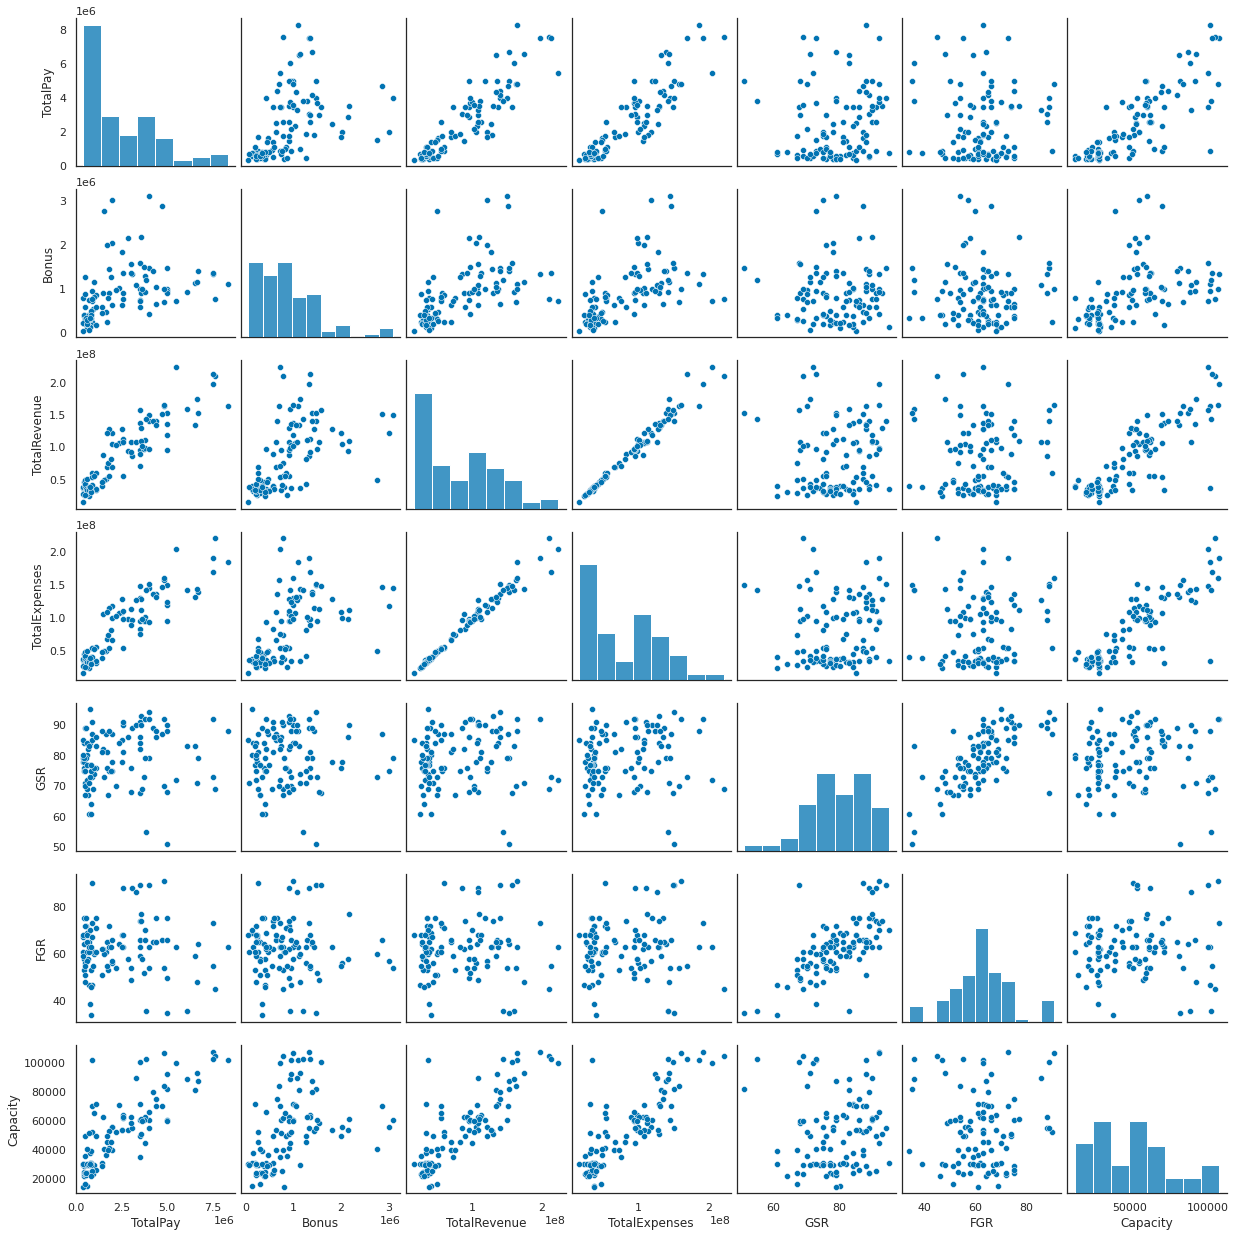

In [ ]:
#Pairplot with first group
print(sns.pairplot(salG1))

##### Relationship with **TotalPay** from group1:

* Bonus: + linear
* TotalRevenue: + linear (looser spread than Total Expenses; steeper slope)
* TotalExpenses: + linear (tighter spread than Total Revenue)
* Capacity: + linear

Weak or no relationship with **TotalPay** from group1:
* GSR: faint positive
* FGR: No relation

##### How do these patterns change when we add Conference in?

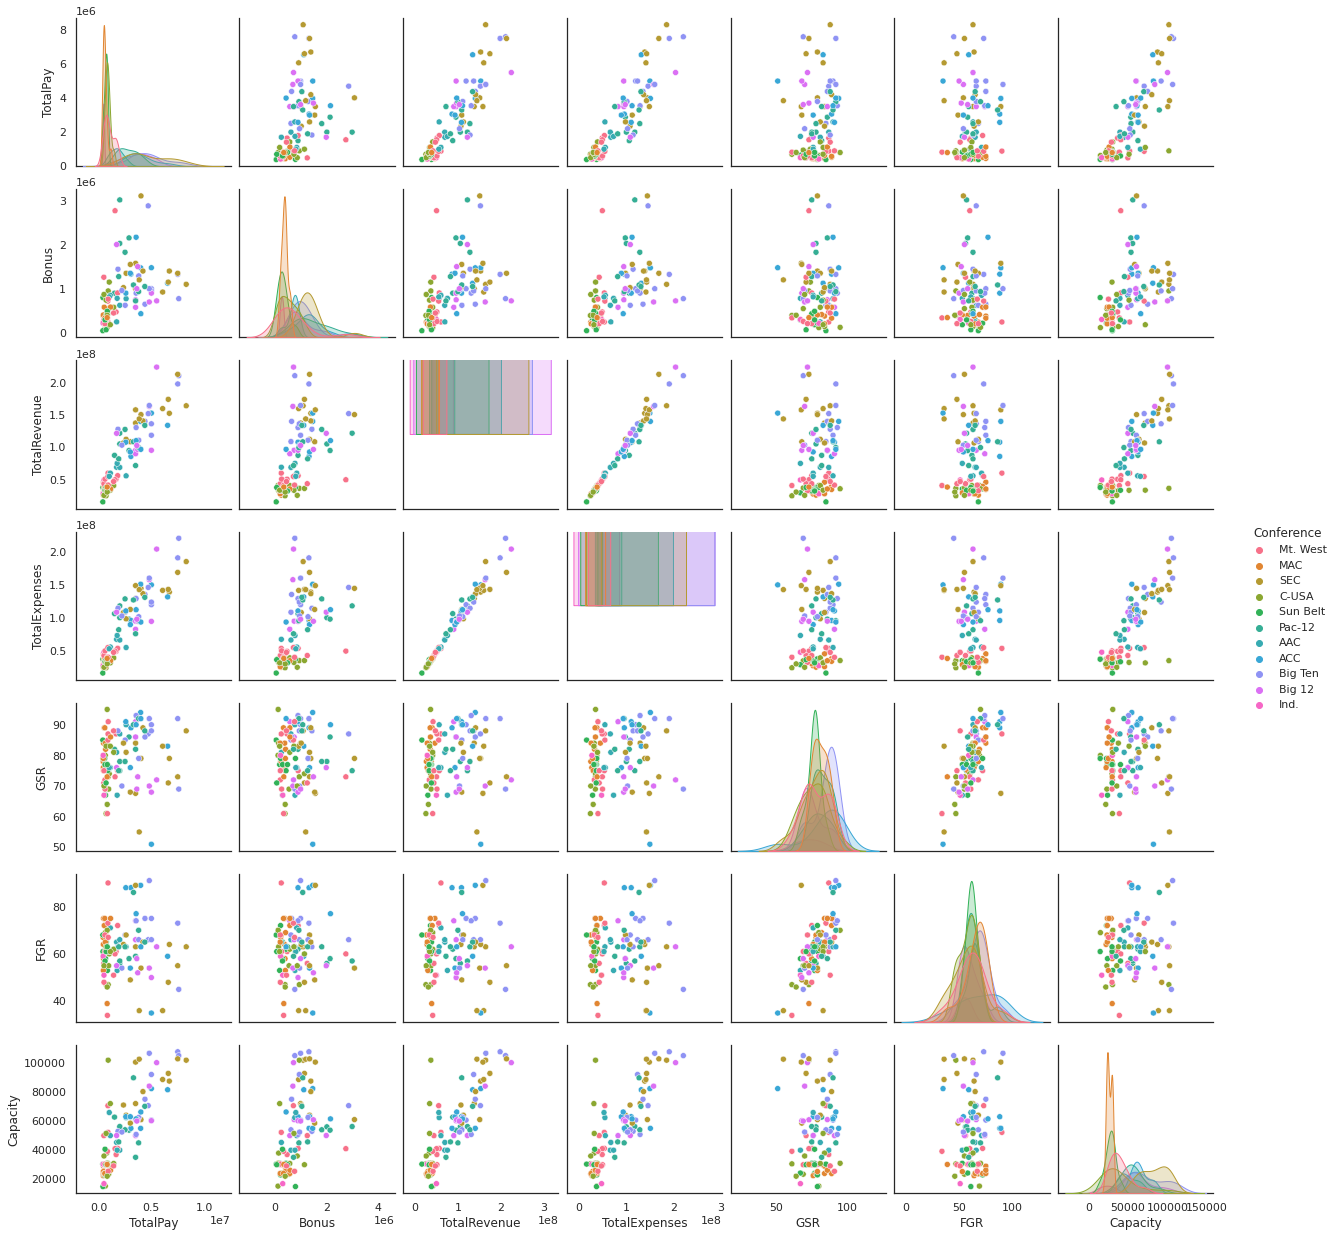

In [ ]:
print(sns.pairplot(salG1, hue='Conference'))

##### Conference Trends:
  * Independent: clustered nearest to the bottom
  * SEC: consistently dispersed all throughout.
  * Big10 & Big12: upper central
  * PAC12 & AAC: consistently central 

* Note that in TotalPay, the above observations do not always hold.

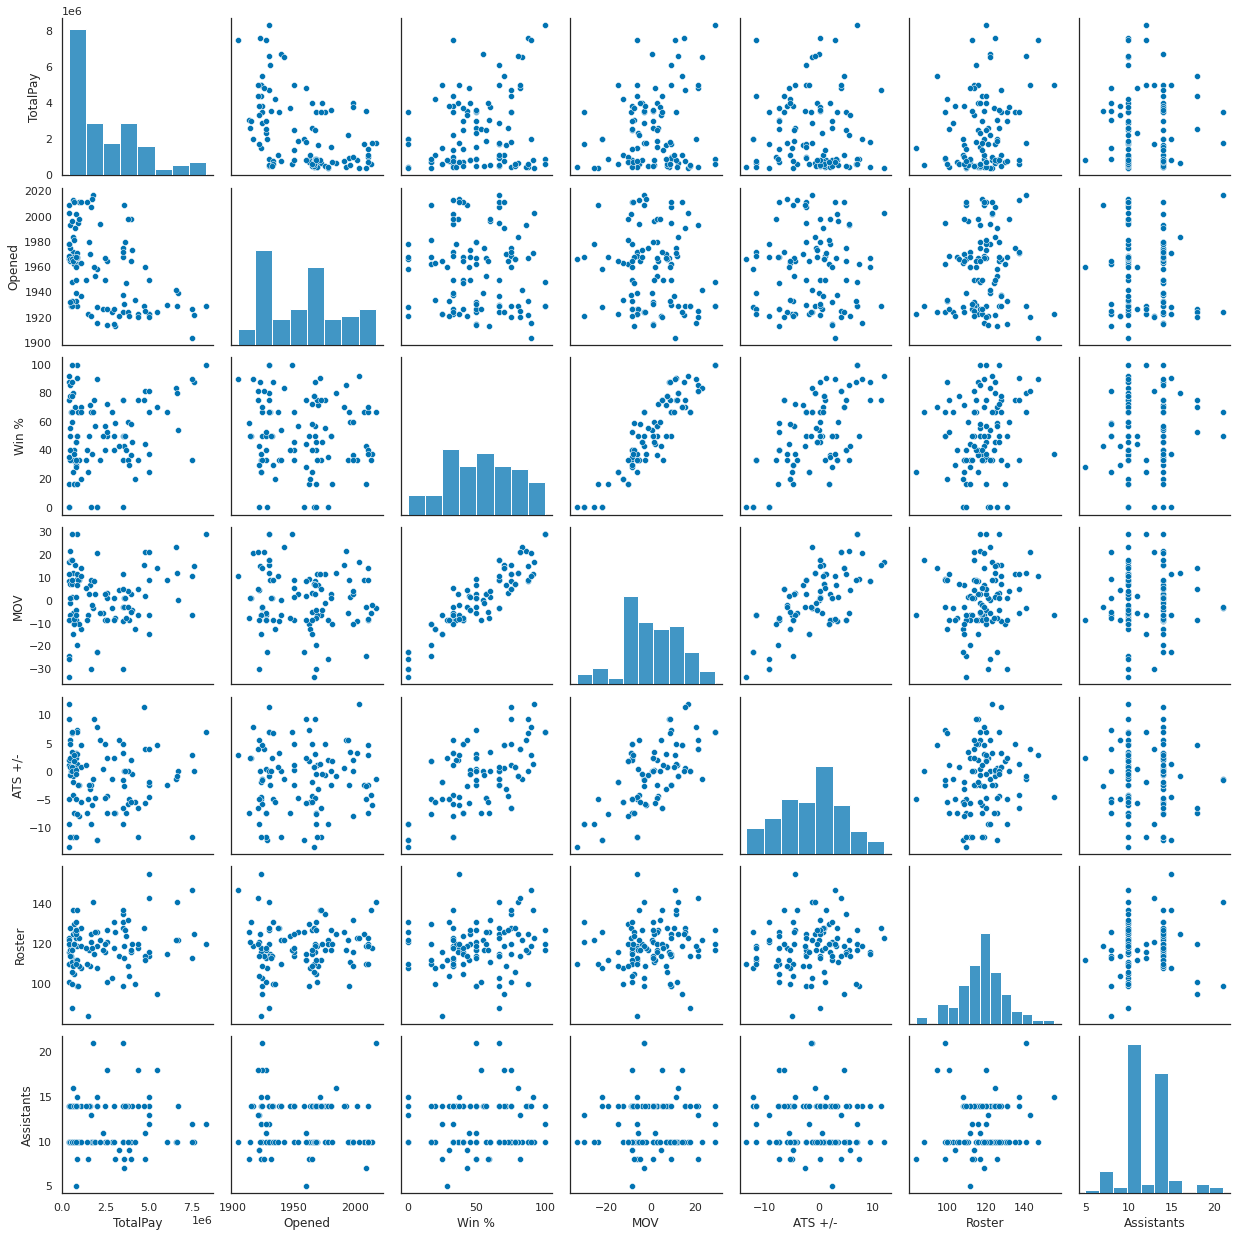

In [ ]:
#Pairplot with second group
print(sns.pairplot(salG2))

##### Weak or no relationship with **TotalPay** from group2:

* Opened: - linear weak
* Win %, MOV, ATR: + linear very weak
* Roster & Assistants: more of a centralized cloud

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


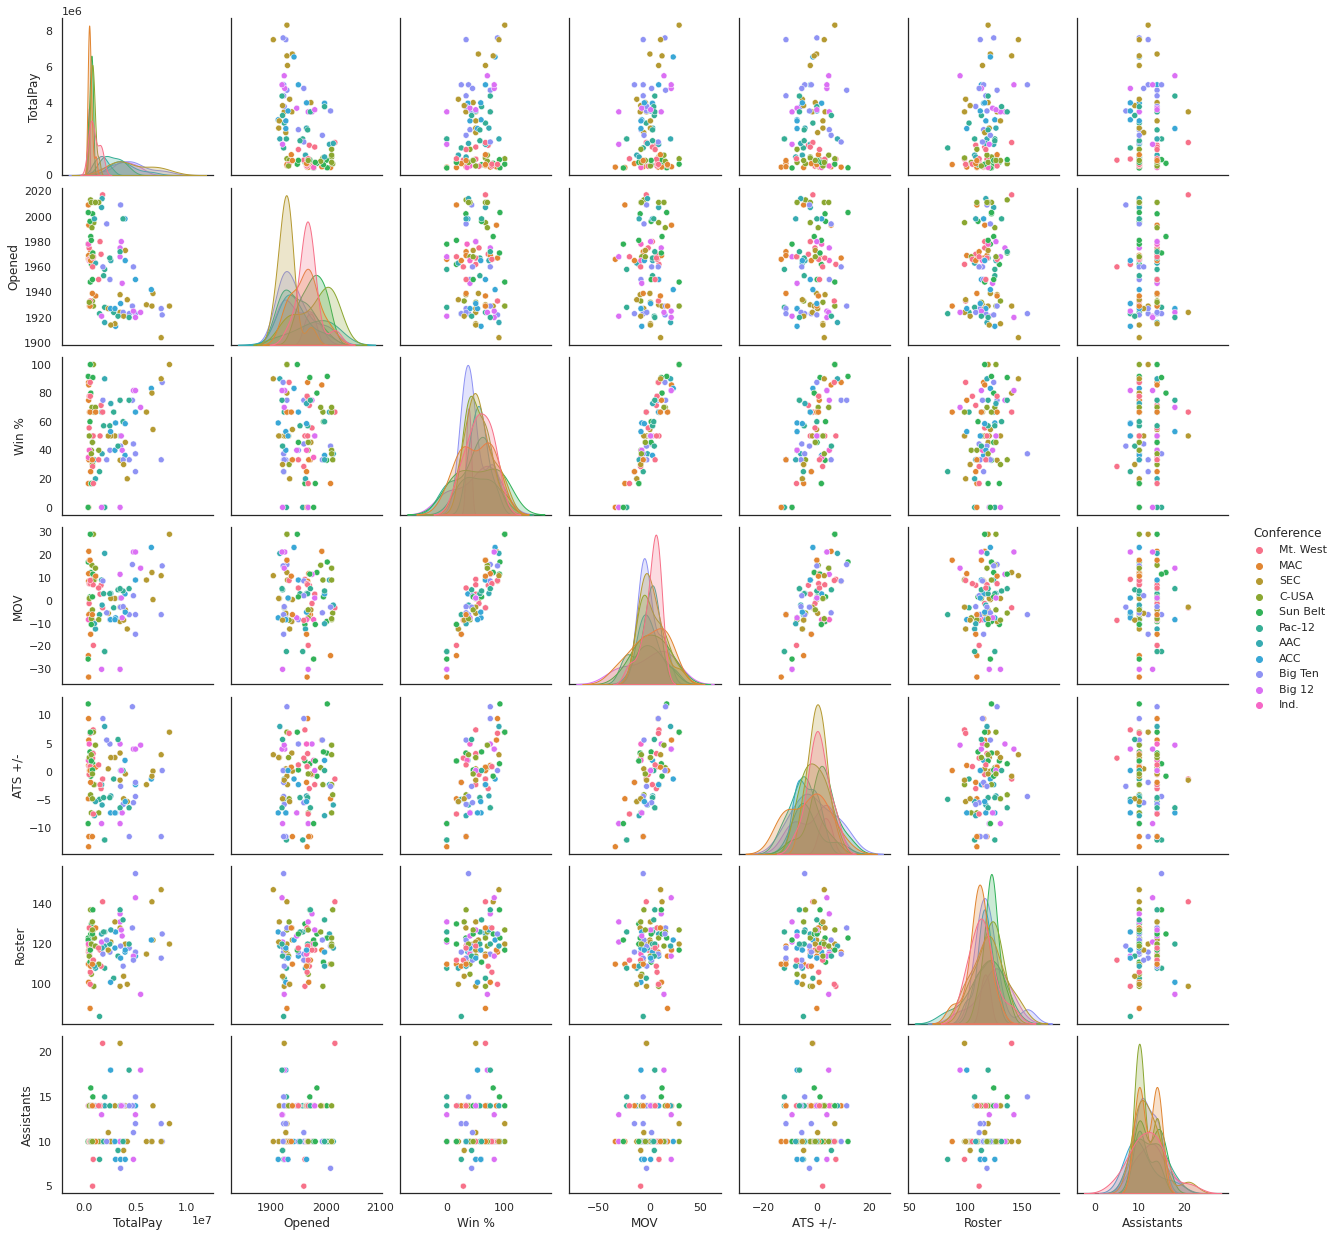

In [ ]:
print(sns.pairplot(salG2, hue='Conference'))

* Similar trends in conference to what was seen in the first group.

#### Scatterplot Summary

* Variables with strong relations to TotalPay:
  * Bonus, TotalRevenue, TotalExpense, & Capacity

* Variables with weak realtions to TotalPay:
  * GSR & Opened

* Variables with almost no relationship to TotalPay:
  * Win %, MOV, ATR, Roster, & Assistants

### Scatterplot to choose Expenses or Revenue

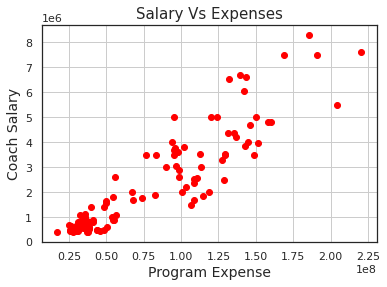

In [ ]:
plt.scatter(salary['TotalExpenses'], salary['TotalPay'], color='red')

plt.title('Salary Vs Expenses', fontsize=15)
plt.xlabel('Program Expense', fontsize=14)
plt.ylabel('Coach Salary', fontsize=14)
plt.grid(True)
plt.show()

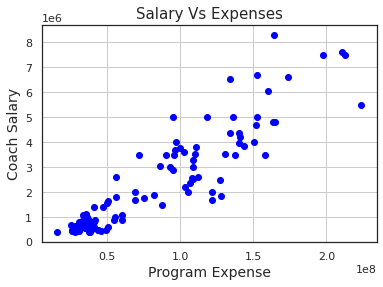

In [ ]:
plt.scatter(salary['TotalRevenue'], salary['TotalPay'], color='blue')

plt.title('Salary Vs Expenses', fontsize=15)
plt.xlabel('Program Expense', fontsize=14)
plt.ylabel('Coach Salary', fontsize=14)
plt.grid(True)
plt.show()

### Barcharts for categorical variables

In [ ]:
#Subset the desired variables into a new df
categor = salary[['TotalPay', 'Conference', 'School', 'Coach']]
# Group by Conferemce
categorGrp = categor.groupby('Conference', as_index=False).agg({"TotalPay": "sum"})
# Sort by Total Pay Descending
categorSort = categorGrp.sort_values('TotalPay', ascending=False)

##### Conference by TotalPay

###### Barplot

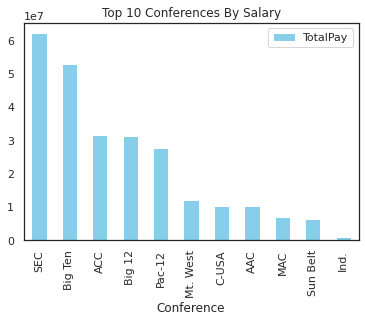

In [ ]:
#Make a bar chart to show dispersion of TotalPay by Conference
categorSort.iloc[:11].plot.bar( x = 'Conference', y ='TotalPay', color = 'skyblue', title = 'Top 10 Conferences By Salary')

###### BoxPlot

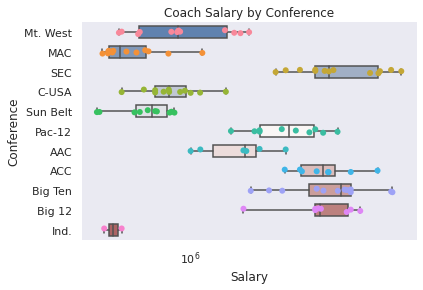

In [ ]:
#Total pay is clearly widely vaired among conferences. Let's try transforming that variable to create an easier to see spread.
sns.set_theme(style='dark')
#Initilaize figure with logarithmic axis
f, ax = plt.subplots()
ax.set_xscale("log")
#Plot our desired information
sns.boxplot(x ='TotalPay', y='Conference', data=categor, whis=[0,100], width=.6, palette='vlag') #Transforming the x-axis DOES make a difference in how clearly we can see.
#Show each observation with a point
sns.stripplot(x='TotalPay', y='Conference', data=categor, size=6)
#Mess with some of the presentation
sns.despine(trim=True, left=True)
ax.set_title("Coach Salary by Conference")
ax.set(xlabel='Salary')

plt.show()

###### Confernce Summary

It is clear that what conference your School is in impacts the salary you would receive. This variable needs to be included in our analysis.

##### School by TotalPay

In [ ]:
#Make a bar chart to show top 10 schools by TotalPay and top 10 Coaches by TotalPay
categorSort = categor.sort_values('TotalPay', ascending=False)
categorTop10 = categorSort.iloc[:10]
categorBtm10 = categorSort.iloc[-10:]

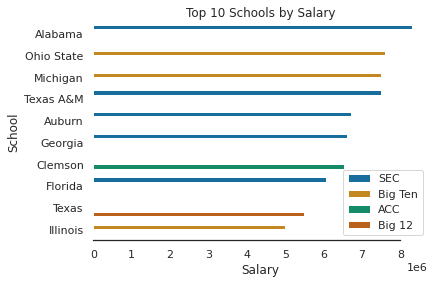

In [ ]:
sns.set_theme(palette="colorblind", style="white")
#Initialize plot
f, ax = plt.subplots()
#Make bar chart for TOP 10 SCHOOLS
sns.barplot(x='TotalPay', y='School', hue='Conference', data=categorTop10)
#Edit visuals
sns.despine(trim=True, left=True)
ax.set_title("Top 10 Schools by Salary")
ax.set(xlabel='Salary')
plt.legend(loc='lower right')
plt.show()

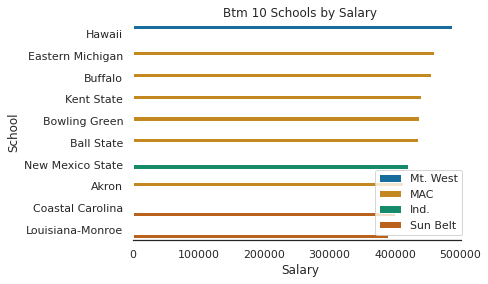

In [ ]:
sns.set_theme(palette="colorblind", style="white")
#Initialize plot
f, ax = plt.subplots()
#Make a bar chart for BTM 10 SCHOOLS
sns.barplot(x='TotalPay', y='School', hue='Conference', data=categorBtm10)
#Edit visuals
sns.despine(trim=True, left=True)
ax.set_title("Btm 10 Schools by Salary")
ax.set(xlabel='Salary')
plt.legend(loc='lower right')
plt.show()

Expense and Revenue are so similar in their relationship with Salary. For now, create a model using them one at a time to decide who is a better fit.

#####3 School Summary

It is important to note that while Conference has a clear impact on Coach Salary, the School clearly contributes. We can see this by the above plot showing the top 10 Schools, ranked by Salary. Not all of the top 10 Schools are from the same Conference.

We will include School in our Analysis.

#### Coach by Total Pay

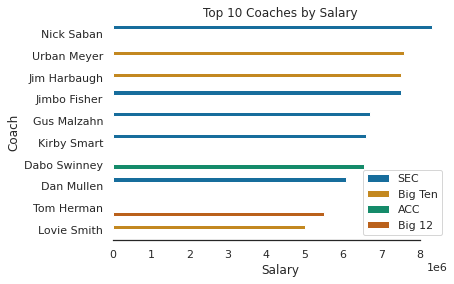

In [ ]:
#Top 10 Coaches
sns.set_theme(palette="colorblind", style="white")
#Initialize plot
f, ax = plt.subplots()
#Make bar chart for TOP 10 SCHOOLS
sns.barplot(x='TotalPay', y='Coach', hue='Conference', data=categorTop10)
#Edit visuals
sns.despine(trim=True, left=True)
ax.set_title("Top 10 Coaches by Salary")
ax.set(xlabel='Salary')
plt.legend(loc='lower right')
plt.show()

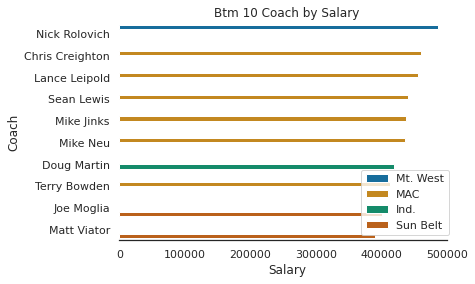

In [ ]:
#Btm 10 Coaches
sns.set_theme(palette="colorblind", style="white")
#Initialize plot
f, ax = plt.subplots()
#Make a bar chart for BTM 10 SCHOOLS
sns.barplot(x='TotalPay', y='Coach', hue='Conference', data=categorBtm10)
#Edit visuals
sns.despine(trim=True, left=True)
ax.set_title("Btm 10 Coach by Salary")
ax.set(xlabel='Salary')
plt.legend(loc='lower right')
plt.show()

##### Coach Summary

Similarly to School, the Coach does have an effect on the Salary.

However, I would argue that the School is a better variable to consider for our business case. This is because we do not have any information about how long any Coach' tenure has been. If we had included that, it would be an interesting factor to consider. Without that, the identity of the coach is tied to the School they are at. We will only utilize School going forward.

# Models

#### Sources

* https://realpython.com/train-test-split-python-data/
* https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/

#### Variables of Interest

* **Dependant Variable**: 
  * TotalPay (Coach Salary)

* **Independant Variables**:
  * School
  * Conference
  * Bonus
  * Total Revenue OR Total Expenses
  * Capacity
  * Graduation Success Rate (GSR)
  * Opened (Year stadium opened)
  * Win % (Very weak relationship)


#### Sequential Multivariate Regression

In [ ]:
#Select the Variables we identified as having a correlation and relationship with TotalPay
regress = salary.drop('Coach',axis=1)

##### Make Dummy Variables for Categorical Variables (Conference & School)

In [ ]:
# To play with
play = regress
#Create Dummy variables for the two Categorical Variables: Conference & School

### CONFERENCE
conf = pd.get_dummies(play['Conference'], drop_first=True)
# Drop extra column (Conference) from play
play = play.drop('Conference', axis=1)
# Concat the new dummy variable back to PLAY
play = pd.concat([play, conf], axis=1)

### SCHOOL
scho = pd.get_dummies(play['School'], drop_first=True)
# Drop extra column (Conference) from play
play = play.drop('School', axis=1)
# Concat the new dummy variable back to PLAY
play = pd.concat([play, scho], axis=1)

In [ ]:
#For use in regression
regressDummy = play

In [ ]:
regressDummy = regressDummy.rename(columns={'Pac-12':'Pac Twelve', 'Ind.':'Ind', 'Win %':'WinP', 'Big 12':'BigTwelve', 'Big Ten':'BigTen', 'C-USA':'CUSA', 'Mt. West':'MtWest', 'Pac-12':'PacTwelve', 'Sun Belt':'SunBelt', 'ATS +/-':'ATS' })

##### Regression with all Variables using sklearn

In [ ]:
### Separate dependent and independent variables

x = regressDummy.drop('TotalPay',axis=1)
y = regressDummy[['TotalPay']]

In [ ]:
### Split data into test and train data using sklearn train_test_split

#We tell it we want to receive a train and test set for x and a train and test set for y. These will be arrays.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42) #test_size shows the proportion of events we want to have in our test select. We chose 30%.
                                                                                          #random_state is how we are randomizing the event selection for each group.

In [ ]:
### Look at what we made
#print(x_train.head(n=3))
#print(y_train.head(n=3))
#print(x_test.head(n=3))
#print(y_test.head(n=3))

  #Look good. Output is a little long what with all of the dummy variables.

In [ ]:
### Try running our first Model

LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
### Make predictions on our Test Data

y_prediction =  LR.predict(x_test)
y_prediction

array([[5852619.43424362],
       [ 225576.78395098],
       [ 149659.91451473],
       [ 981201.67632192],
       [1602564.83747741],
       [3195691.54138775],
       [1020975.67796888],
       [4679001.03634039],
       [-168780.89956624],
       [ 172285.28489051],
       [1986279.25386791],
       [ 758451.43568604],
       [3551494.67694524],
       [ 469129.85637465],
       [2661119.3817442 ],
       [ 663662.28044667],
       [-427635.7798272 ],
       [3844240.12094357],
       [  -6480.36010431],
       [ 981918.377481  ],
       [4340452.57603453],
       [4680973.79618189],
       [1193055.88266575],
       [5313609.03917046],
       [ -39521.18393231],
       [5781668.12054715],
       [2440079.93466216],
       [ 334720.56831395],
       [3430339.487519  ],
       [4549835.20716347],
       [4241027.92456578],
       [1252941.49323081]])

In [ ]:
### Use predictions to determine Accurracy

score=r2_score(y_test,y_prediction)
print('r2 socre is',score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is 0.8414412692957357
mean_sqrd_error is== 545736179406.13104
root_mean_squared error of is== 738739.5883571769


###### Sklearn Regression Results

* R-squared: 84.1%
* Mean quared error: 545,736,179,406
* Root mean square error: 738,740

##### Regression with all Quantitative Variables (Total Expenses) using statsmodels

In [ ]:
regressDummy.head(n=2)

,TotalPay,Bonus,TotalRevenue,TotalExpenses,GSR,FGR,Capacity,Opened,WinP,MOV,ATS,Roster,Assistants,ACC,BigTwelve,BigTen,CUSA,Ind,MAC,MtWest,PacTwelve,SEC,SunBelt,Akron,Alabama,Alabama at Birmingham,Appalachian State,Arizona,Arizona State,Arkansas,Arkansas State,Auburn,Ball State,Boise State,Bowling Green,Buffalo,California,Central Florida,Central Michigan,Charlotte,Cincinnati,Clemson,Coastal Carolina,Colorado,Colorado State,East Carolina,Eastern Michigan,Florida,Florida Atlantic,Florida International,Florida State,Fresno State,Georgia,Georgia Southern,Georgia State,Georgia Tech,Hawaii,Houston,Illinois,Indiana,Iowa,Iowa State,Kansas,Kansas State,Kent State,Kentucky,LSU,Louisiana Tech,Louisiana-Lafayette,Louisiana-Monroe,Louisville,Marshall,Maryland,Massachusetts,Memphis,Miami (Ohio),Michigan,Michigan State,Middle Tennessee,Minnesota,Mississippi,Mississippi State,Missouri,Nebraska,Nevada,Nevada-Las Vegas,New Mexico,New Mexico State,North Carolina,North Carolina State,North Texas,Northern Illinois,Ohio,Ohio State,Oklahoma,Oklahoma State,Oregon,Oregon State,Penn State,Purdue,Rutgers,San Diego State,San Jose State,South Alabama,South Carolina,South Florida,Southern Mississippi,Tennessee,Texas,Texas A&M,Texas State,Texas Tech,Texas-El Paso,Texas-San Antonio,Toledo,Troy,UCLA,Utah,Utah State,Virginia,Virginia Tech,Washington,Washington State,West Virginia,Western Kentucky,Western Michigan,Wyoming
0,885000,247000,60009782,54192115,87.00,90.00,52237,1962,50.00,9.30,7.40,99,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,412500,225000,37194485,37275978,78.00,67.00,30000,2009,16.70,-24.20,-4.80,110,10,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
### Generate a simple model 

my_model1 = str('TotalPay ~ Bonus + TotalExpenses + Capacity + GSR + FGR + Opened + WinP + ATS + Roster + Assistants')

# fit the model to the training set
model_fit1 = smf.ols(my_model1, data = regressDummy).fit()

# summary of model fit to the training set
print(model_fit1.summary())



                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     80.47
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.34e-41
Time:                        04:28:49   Log-Likelihood:                -1553.1
No. Observations:                 105   AIC:                             3128.
Df Residuals:                      94   BIC:                             3157.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.633e+06   5.38e+06     -0.303

###### Regression Results with Quantitative Variables(Expenses)

* Ran my_model1
* Prob(F-Statistic): Significant
* Adjusted R-Squared: 88.4%
*  P>|t| Our significant coefficients at the 90% level (p < 0.1) are:
  * Total Expenses + Capacity + FGR + FGR + WinP + ATS + Roster

##### Regression with all Quantitative Variables (Total Revenue) using statsmodels

In [ ]:
### Generate a simple model 

my_model2 = str('TotalPay ~ Bonus + TotalRevenue + Capacity + GSR + FGR + Opened + WinP + ATS + Roster + Assistants')

# fit the model to the training set
model_fit2 = smf.ols(my_model2, data = regressDummy).fit()

# summary of model fit to the training set
print(model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     77.30
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           7.11e-41
Time:                        04:28:49   Log-Likelihood:                -1555.0
No. Observations:                 105   AIC:                             3132.
Df Residuals:                      94   BIC:                             3161.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.855e+06   5.48e+06     -0.338   

###### Regression Results with Quantitative Variables(Revenue)

* Ran my_model2
* Prob(F-Statistic): Significant
* Adjusted R-Squared: 88.0%
* P>|t| Our significant coefficients at the 90% level (p < 0.1) are:
  * Total Revenue + + Capacity + FGR + FGR + WinP + ATS + Roster

##### Regression with Variables Determined by Correlation & Scatter Plots

* Utilize Total Expenses instead of Total Revenue as it has a higher adjusted R-squared and more variables whose coefficients are significant.

In [ ]:
### Generate a simple model 

my_model3 = str('TotalPay ~ Bonus + TotalExpenses + Capacity + GSR + FGR + Opened + WinP + ACC + BigTwelve + BigTen + CUSA + Ind + MAC + MtWest + PacTwelve + SEC + SunBelt')

# fit the model to the training set
model_fit3 = smf.ols(my_model3, data = regressDummy).fit()

# summary of model fit to the training set
print(model_fit3.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     35.81
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           5.47e-32
Time:                        04:28:49   Log-Likelihood:                -1562.5
No. Observations:                 105   AIC:                             3161.
Df Residuals:                      87   BIC:                             3209.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.147e+06   6.47e+06     -0.641

###### Regression Results with Variables Determined by Correlation & Scatter Plots

* Ran my_model3
* Prob(F-Statistic): Significant
* Adjusted R-Squared: 85.1%
* P>|t| Our significant coefficients at the 90% level (p < 0.1) are:
  * Expenses + Capacity + FGR + GSR + WinP

Note that including the conferences is causing a reduction in predictive ability.

##### Regression with Significant Variables (Expenses, Capacity, FGR, GSR, WinP) & Conferences

In [ ]:
my_model4 = str('TotalPay ~ TotalExpenses + Capacity + FGR + GSR + WinP + ACC + BigTwelve + BigTen + CUSA + Ind + MAC + MtWest + PacTwelve + SEC + SunBelt')

# fit the model to the training set
model_fit4 = smf.ols(my_model4, data = regressDummy).fit()

# summary of model fit to the training set
print(model_fit4.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     40.33
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           3.95e-33
Time:                        04:28:49   Log-Likelihood:                -1563.8
No. Observations:                 105   AIC:                             3160.
Df Residuals:                      89   BIC:                             3202.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.424e+06   8.74e+05     -2.775

###### Regression Results with Expenses, Capacity, FGR, WinP, Conferences

* Ran my_model4
* Prob(F-Statistic): Significant
* Adjusted R-Squared: 85.0%
* P>|t| Our significant coefficients at the 90% level (p < 0.1) are:
  * Expenses + Capacity + WinP + FGR +GSR
  * None of the Conferences have a significant coefficient.

##### Regression with Significant Quantitative Variables(Expenses) + Conference + School Using StatsModel

In [ ]:
regressSig = regressDummy.drop(['TotalRevenue', 'Opened', 'Bonus', 'MOV', 'ATS', 'Roster', 'Assistants'], axis=1)

In [ ]:
#Since we want to run so many columns, it is easier to use drop notation than to specify each one.
XVar = regressSig.drop('TotalExpenses', axis=1)
YVar = regressSig[['TotalExpenses']]

#Build linear regression model
my_model5 = sm.OLS(YVar, XVar).fit()

#Look at the results
print(my_model5.summary())

                            OLS Regression Results                            
Dep. Variable:          TotalExpenses   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Mon, 26 Jul 2021   Prob (F-statistic):                nan
Time:                        04:28:49   Log-Likelihood:                 847.10
No. Observations:                 105   AIC:                            -1484.
Df Residuals:                       0   BIC:                            -1206.
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TotalPay                 11.68

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


#### Model Dealing with School Dummy Variables

Note that when dummy variables are created for every single school in the data frame (105 Schools) that regression breaks down. 

I am unsure of how to deal with this because I feel that just selecting Schools of interest is highly inappropriate.

Googling this issue presents the possibility of fusing the categories but no one seems to have provided a clear answer for how to do this. 

I propose that if I break the data frame down into Conferences, there may be a small enough number of dummy variables to allow for regression.

##### Separating DF by Conference

We will start with the freshly joined and edited df, *salary*. We will remove the variables that were not significant in our previous regression analysis, separate into df by conference, then create dummy variables in each new df and run OLS regression on each.

In [ ]:
split = salary.drop(['TotalRevenue', 'Coach', 'Opened', 'MOV'], axis=1)
split = split.rename(columns={'Win %':'WinP', 'TotalPay':'Salary', 'TotalExpenses':'Expenses', 'ATS +/-': 'ATS'})

In [ ]:
split['Conference'].unique()

array(['Mt. West', 'MAC', 'SEC', 'C-USA', 'Sun Belt', 'Pac-12', 'AAC',
       'ACC', 'Big Ten', 'Big 12', 'Ind.'], dtype=object)

In [ ]:
#Create a DF containing the records of each conference (11 conferences represented)
MtWest = split[split['Conference']=='Mt. West']
MAC = split[split['Conference']=='MAC']
SEC = split[split['Conference']=='SEC']
CUSA = split[split['Conference']=='C-USA']
SunBelt = split[split['Conference']=='SunBelt']
PacTwelve = split[split['Conference']=='Pac-12']
AAC = split[split['Conference']=='AAC']
ACC = split[split['Conference']=='ACC']
BigTen =split[split['Conference']=='Big Ten']
BigTwelve = split[split['Conference']=='Big 12']
Inde = split[split['Conference']=='Ind.']

In [ ]:
#Create dummy varibles for School and Conference in each Conference DF
MtWest = pd.get_dummies(MtWest, columns=['School','Conference'], drop_first=True)
MAC = pd.get_dummies(MAC, columns=['School', 'Conference'], drop_first=True)
SEC = pd.get_dummies(SEC  , columns=['School', 'Conference'], drop_first=True)
CUSA = pd.get_dummies(CUSA, columns=['School', 'Conference'], drop_first=True)
SunBelt = pd.get_dummies(SunBelt, columns=['School', 'Conference'], drop_first=True)
PacTwelve = pd.get_dummies(PacTwelve, columns=['School', 'Conference'], drop_first=True)
AAC = pd.get_dummies(AAC, columns=['School', 'Conference'], drop_first=True)
ACC = pd.get_dummies(ACC, columns=['School', 'Conference'], drop_first=True)
BigTen = pd.get_dummies(BigTen, columns=['School', 'Conference'], drop_first=True)
BigTwelve = pd.get_dummies(BigTwelve, columns=['School', 'Conference'], drop_first=True)
Inde = pd.get_dummies(Inde, columns=['School', 'Conference'], drop_first=True)


###### MtWest Conference Regression

In [ ]:
MtWest.dtypes

Salary                       int64
Bonus                        int64
Expenses                     int64
GSR                        float64
FGR                        float64
Capacity                     int64
WinP                       float64
ATS                        float64
Roster                       int64
Assistants                   int64
School_Boise State           uint8
School_Colorado State        uint8
School_Fresno State          uint8
School_Hawaii                uint8
School_Nevada                uint8
School_Nevada-Las Vegas      uint8
School_New Mexico            uint8
School_San Diego State       uint8
School_San Jose State        uint8
School_Utah State            uint8
School_Wyoming               uint8
dtype: object

In [ ]:
XVar = MtWest.drop('Salary', axis=1)
YVar = MtWest[['Salary']]

#OLS model
MtWestModel = sm.OLS(YVar, XVar).fit()
#Summary Stats
print(MtWestModel.summary())    

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Mon, 26 Jul 2021   Prob (F-statistic):                nan
Time:                        04:28:49   Log-Likelihood:                 199.40
No. Observations:                  12   AIC:                            -374.8
Df Residuals:                       0   BIC:                            -369.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Bonus                     

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


###### MtWest Conference Regression Results

Separating by Conference is not the solution.

* Instead of using dummy variables that create a sparse matrix, can I create dummy variables that just replaces each unique conference or each unique school with a unique number?

#### Create Dummy Variables that do not result in a Sparse Matrix

In [ ]:
#Use split data frame as it has only the variables of interest
splitPlay = split
splitPlay['Conference'] = pd.factorize(splitPlay.Conference)[0] +1
splitPlay['School'] = pd.factorize(splitPlay.School)[0] +1

#### Run new Regression Analysis
* Include some variables that were previously removed to see effect of School and Conference being included.

In [ ]:
XVar = splitPlay.drop("Salary", axis=1)
YVar = splitPlay[["Salary"]]
#Add in the constant
XVar2 = sm.add_constant(XVar)

splitPlay1=sm.OLS(YVar, XVar2).fit() 
print(splitPlay1.summary())    


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     72.10
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.45e-40
Time:                        04:28:49   Log-Likelihood:                -1553.3
No. Observations:                 105   AIC:                             3131.
Df Residuals:                      93   BIC:                             3162.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.166e+06   9.55e+05     -5.410      0.0

In [ ]:
#Remove Assistants from the predictor variables
model2 = str('Salary ~ School + Conference + Bonus + Expenses + GSR + FGR + Capacity + WinP + ATS + Roster')
#Fit the model
model2fit = smf.ols(model2, data = splitPlay).fit()
#Show summary statistics
print(model2fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     79.77
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.92e-41
Time:                        04:28:50   Log-Likelihood:                -1553.5
No. Observations:                 105   AIC:                             3129.
Df Residuals:                      94   BIC:                             3158.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.311e+06   9.25e+05     -5.744      0.0

In [ ]:
# Try removing ATS and FGR to see if the model improves
model3 = str('Salary ~ School + Conference + Bonus + Expenses + FGR + Capacity + WinP + Roster')
#Fit the model
model3fit = smf.ols(model3, data = splitPlay).fit()
#Show summary statistics
print(model3fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     85.66
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           2.80e-40
Time:                        04:28:50   Log-Likelihood:                -1561.6
No. Observations:                 105   AIC:                             3141.
Df Residuals:                      96   BIC:                             3165.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.955e+06   8.92e+05     -4.432      0.0

In [ ]:
# Try from few variables and add in one at a time to see if we can beat 88.3% R-Squared
#Use salary DF
salaryPlay = salary.rename(columns={'TotalPay':'Salary', 'TotalRevenue':'Revenue', 'TotalExpenses':'Expenses', 'Win %':'WinP', 'ATS +/-':'ATS'})
salaryPlay['Conference'] = pd.factorize(salaryPlay.Conference)[0] +1
salaryPlay['School'] = pd.factorize(salaryPlay.School)[0] +1
salaryPlay
#Select Variables
model4 = str('Salary ~ School + Conference + Expenses + Capacity + GSR + WinP + Roster')
#Fit the model
model4fit = smf.ols(model4, data = salaryPlay).fit()
#Show summary statistics
print(model4fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     95.14
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.39e-40
Time:                        04:28:50   Log-Likelihood:                -1563.3
No. Observations:                 105   AIC:                             3143.
Df Residuals:                      97   BIC:                             3164.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.357e+06   9.86e+05     -5.434      0.0

##### New Regression Results

**Model splitPlay1:**
* F-Stat: significant
* Adjusted R-squared: 88.3%
* Insignificant coefficients: 
  * Assistants

**Model splitPlay2:**
* F-Stat: significant
* Adjusted R-squared: 88.3%
* All variables other than School and Conference are statistically significant.

**Model splitPlay3**
* F-stat: significant
* Adjusted R-squared: 86.8 %
* School, Confernce, and FGR are not significant.

**Model splitPlay4**
* F-stat:Significant
* Adjusted R-squared: 86.4%
* School, Confernce, and GSR are not significant.


# Analysis

I utilized linear regression to create models to attempt to predict the Salary of a Football coach in the NCAA. Data was collected from multiple sources (as listed in the introduction) and joined together to make this analysis more powerful. The variables that were analyzed for having an effect on Salary were: Conference, School, Revenue, Expenses, Coach Bonus, Graduation Success Rate (GSR), Federal Graduation Rate (FGR), Stadium Capacity, year Stadium was Opened, Win %, Against The Spread, Margin of Victory, Number of students on their Roster, and number of Assistant Head Coaches.

Attempting to create dummy variables for the categorical attributes resulted in regression that gave meaningless results; all R-squared = 1 and no coefficients could be generated. Instead, I utilized factorization to allow for having each unique occurence in a column have a number from 1 to n. This allowed me to incorporate both School and Conference into my analysis. The only reason why I am chosing to include them (their coefficients are never significant) is because of the questions asked in the lab.

Across the models I ran, a number of variables consistently had significant coefficient values in the regression. These are: Bonus, Expenses, Revenue, Stadium Capacity, GSR, FGR, Win %, Roster, ATS, & Assistants. Not all of these were significant at the same time and you can see which ones were included in my best fitting models.

Another important point of note is correlation seen between some of the predictive variables. Expenses and Revenue, GSR and FGR, Win% and MOV were highly correlated in the listed pairs. Bonus was > 0.3 with expense and capacity and Expense/Revenue were > 0.3 with Capacity and opened. Because of these relationships, I consider the best model below to be splitPlay4. It's R-squared is only 2% less than the highest r-square model and it contains only 1 of the major predictive variable correlations (Expense and Capacity). All other models contain numerous predicitive variables with high correlation to each other. I will use splitPlaymodel4 to make my predictions for recommendations. 

Based on the scatter plots that were generated, I was surprised to see GSR and Roster show up as variables that significantly effected the model. GSR did have a faint positive trend but Roster was mostly a centralized cloud of data points. None of the other variables included in my model were surprising based on the EDA.

The questions asked in the lab assignement will be answered in the following Recommendation and Questions section.

## Top 6 Models with Highest R-Squared

*myModel1*
* **88.4** % R-squared
* Bonus + TotalExpenses + Capacity + GSR + FGR + Opened + WinP + ATS + Roster + Assistants

*splitPlay1*
* **88.3** % R-squared
* School + Conference + Bonus + Expenses + GSR + FGR + Capacity + WinP + ATS + Roster + Assistants

*splitPlay2*
* **88.3** % R-squared
* School + Conference + Bonus + Expenses + GSR + FGR + Capacity + WinP + ATS + Roster

*myModel2*
* **88.0** % R-squared
* Bonus + TotalRevenue + Capacity + GSR + FGR + Opened + WinP + ATS + Roster + Assistants

*splitPlay3*
* **86.8** % R-squared
* School + Conference + Bonus + Expenses +  FGR + Capacity + WinP + ATS + Assistants

*splitPlay4*
* **86.4** % R-squared
* School + Conference + Expenses + GSR + Capacity + WinP + Roster

# Questions & Recommendation

#### What Schools were dropped and why?

* Army, Boise State, Buffalo, Central Florida, Florida Atlantic,Florida International, Marshall, Mississippi State, N Texas, Rutgers, San Diego State, Southern Mississippi, Texas State, Texas El-Paso, Virginia, Virginia Tech, Washington State, West Virginia, Syracuse.

Most had Bonus missing and the data was not publically available.


#### What is the effect of GSR on Salary?

* Increased GSR = Increased Salary

#### How good is my best model?

* Based on the criteria I gave in my analysis section, my best model accounts for 86.4% of the variability in the prediction of Coach Pay.

#### What is the single biggest impact on Salary amount?

* The largest impact on predicting salary size is number of people on the teams roster. This coefficient is 20K+. The next nearest coefficient is 10K+ for Graduation Success Rate.

#### What is the recommended salary for the Syracuse Coach?

As the Syracuse Coach is missing, I will answer this question for the **Air Force** Coach at **Mount West Conference**.

* predicted salary low = $983,365.68 

* predicted salary high = $1,201,891.38

#### What is the recommended salary for the AirForce Coach in the Big East?

As there is no Big East Confernce, I will answer for **MAC Conference**
* predicted salary low = $975,805.18 

* predicted salary high= $1,192,650.78

#### What is the recommended salary for the AirForce Coach in the Big Ten?

The recommended salary for the AirForce Coach if they were in the Big Ten Conference:
* predicted salary low = $922,881.75

* predicted salary high = $1,127,966.59